In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-weights-of-cbam/trained_model_CRC_CBAM(transform).pth
/kaggle/input/model-weights-of-cbam/trained_model_CRC_CBAM(transform).pkl
/kaggle/input/model-weights-of-cbam/trained_model_CRC_CBAM.pth
/kaggle/input/model-weights-of-cbam/trained_model_CRC_CBAM.pkl
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TPWTCDWW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TVEFEGLW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-CFQTHFME.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-EAEVGGDD.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-TAYDCYET.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-KHTKNTIW.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-KGGQINNF.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-FYEPPFHG.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-VDNKPEAP.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/MUC-TCGA-GARIDRVP.tif
/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K/MUC/

In [3]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=7390c8aba7d667f14570f843f888b12f2b79a284e63cc5178540a04dc401715e
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import joblib
from medmnist import PathMNIST
from collections import Counter
from torchsummary import summary


In [7]:
import torch
import torch.nn as nn
from torchvision import models

# CBAM Block
class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        # Channel Attention
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, kernel_size=1),
            nn.Sigmoid()
        )
        # Spatial Attention
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Channel Attention
        att_c = self.channel_att(x)
        x = x * att_c
        # Spatial Attention
        att_s = self.spatial_att(torch.cat([x.mean(dim=1, keepdim=True), x.max(dim=1, keepdim=True).values], dim=1))
        x = x * att_s
        return x


# Modified EfficientNet-B0 with CBAM for Classification
class ModifiedEfficientNetB0_CBAM(nn.Module):
    def __init__(self, num_classes=9):
        super(ModifiedEfficientNetB0_CBAM, self).__init__()
        self.efficientnet_b0 = models.efficientnet_b0(pretrained=True)

        # Replace SE Blocks with CBAM
        self.cbam1 = CBAMBlock(channels=24)
        self.cbam2 = CBAMBlock(channels=80)
        self.cbam3 = CBAMBlock(channels=320)
        self.cbam4 = CBAMBlock(channels=1280)

        # Modify the final layer for classification
        self.efficientnet_b0.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.efficientnet_b0.features[0:3](x)  # Output channels: 24
        x = self.cbam1(x)

        x = self.efficientnet_b0.features[3:5](x)  # Output channels: 80
        x = self.cbam2(x)

        x = self.efficientnet_b0.features[5:8](x)  # Output channels: 320
        x = self.cbam3(x)

        x = self.efficientnet_b0.features[8:](x)  # Output channels: 1280
        x = self.cbam4(x)

        x = self.efficientnet_b0.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.efficientnet_b0.classifier(x)
        return x


In [8]:
from sklearn.metrics import classification_report

# Define the evaluation function
def evaluate_model(model, dataloader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Append predictions and labels for classification report
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and print the classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)  # Probability of the correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss


In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, dataloaders, dataset_sizes, device, num_epochs=10, learning_rate=0.001, patience=5):
    # Define the criterion (Focal Loss) and optimizer
    criterion = FocalLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model = model.to(device)
    
    # Track losses and accuracies
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Early stopping variables
    best_val_loss = np.inf
    no_improvement_epochs = 0
    best_model_weights = model.state_dict()  # Save the best model weights
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 40)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Conditionally squeeze labels only if they are 2D
                if labels.dim() > 1:
                    labels = labels.squeeze()

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    no_improvement_epochs = 0
                    best_model_weights = model.state_dict()
                else:
                    no_improvement_epochs += 1

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print('-' * 20)

        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    model.load_state_dict(best_model_weights)

    # Plot training and validation loss/accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Val Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s] 


Epoch 1/20
----------------------------------------
train Loss: 0.1329 Acc: 0.8633
--------------------
val Loss: 0.0038 Acc: 0.9714
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.0201 Acc: 0.9306
--------------------
val Loss: 0.0014 Acc: 0.9875
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.0044 Acc: 0.9698
--------------------
val Loss: 0.0010 Acc: 0.9784
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0701 Acc: 0.8918
--------------------
val Loss: 0.0140 Acc: 0.9533
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0216 Acc: 0.9320
--------------------
val Loss: 0.1121 Acc: 0.9561
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0031 Acc: 0.9740
--------------------
val Loss: 0.0683 Acc: 0.9603
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0011 Acc: 

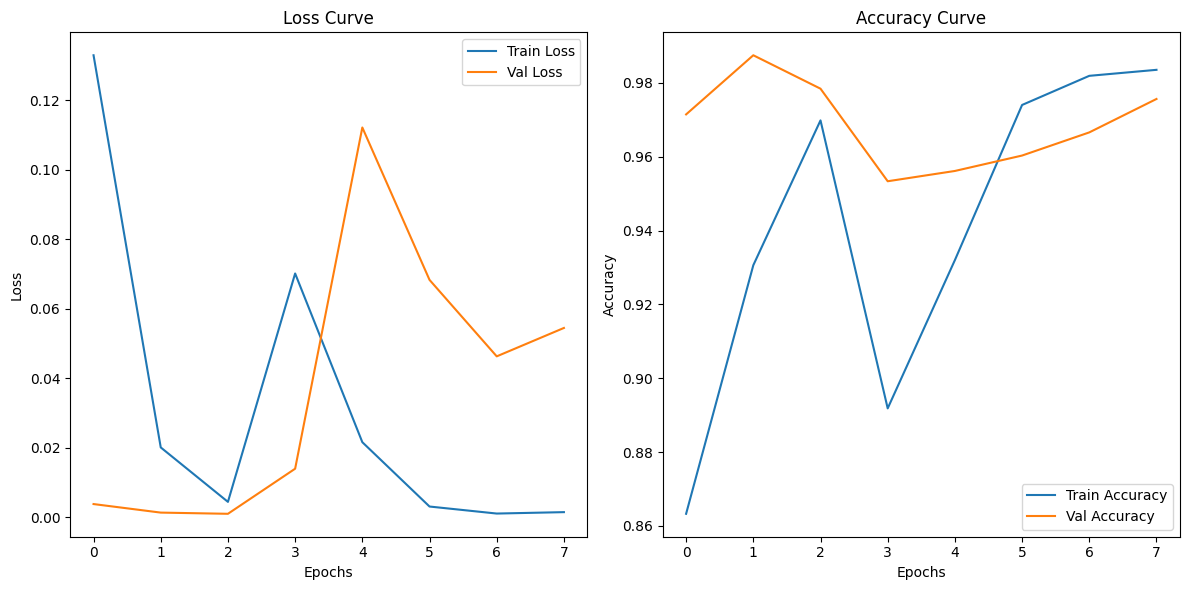

              precision    recall  f1-score   support

         ADI       0.94      1.00      0.97       267
        BACK       1.00      0.88      0.93       169
         DEB       0.96      1.00      0.98        68
         LYM       0.96      1.00      0.98       127
         MUC       0.96      0.97      0.97       207
         MUS       0.99      0.95      0.97       119
        NORM       0.99      0.98      0.98       148
         STR       0.95      0.99      0.97        84
         TUM       1.00      0.99      0.99       247

    accuracy                           0.97      1436
   macro avg       0.97      0.97      0.97      1436
weighted avg       0.97      0.97      0.97      1436



In [9]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load your dataset
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K", transform=transform)

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_CBAM(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)



# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 0.1667 Acc: 0.8377
--------------------
val Loss: 0.1369 Acc: 0.9311
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.0209 Acc: 0.9246
--------------------
val Loss: 0.0019 Acc: 0.9673
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.0056 Acc: 0.9633
--------------------
val Loss: 0.0019 Acc: 0.9812
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0026 Acc: 0.9726
--------------------
val Loss: 0.0010 Acc: 0.9812
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0550 Acc: 0.8960
--------------------
val Loss: 0.0066 Acc: 0.9687
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0226 Acc: 0.9334
--------------------
val Loss: 0.0020 Acc: 0.9701
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0095 Acc: 

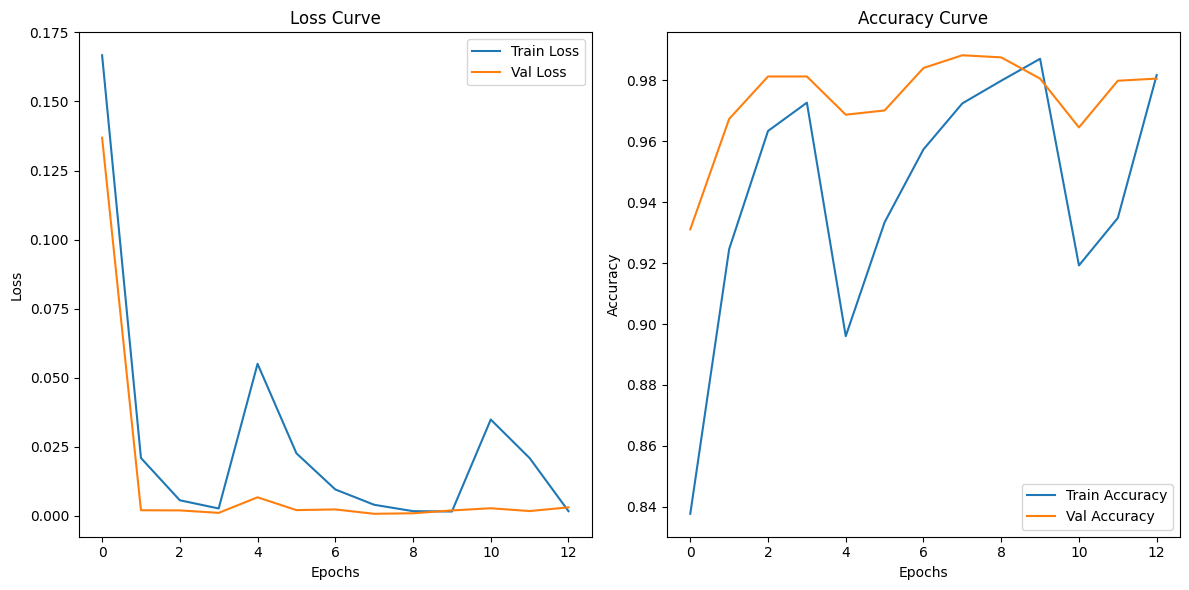

              precision    recall  f1-score   support

         ADI       1.00      1.00      1.00       268
        BACK       1.00      1.00      1.00       169
         DEB       1.00      1.00      1.00        68
         LYM       1.00      1.00      1.00       127
         MUC       1.00      0.99      0.99       207
         MUS       0.83      1.00      0.91       118
        NORM       0.99      0.99      0.99       148
         STR       0.98      0.71      0.83        84
         TUM       0.99      1.00      0.99       247

    accuracy                           0.98      1436
   macro avg       0.98      0.97      0.97      1436
weighted avg       0.98      0.98      0.98      1436



In [17]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load your dataset
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K", transform=transform)

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_CBAM(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)



# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [18]:
joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_CBAM.pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_CBAM.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

Trained Model saved to trained_model_CRC_CBAM.pth


In [19]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

100%|██████████| 205615438/205615438 [01:08<00:00, 3021722.51it/s] 


              precision    recall  f1-score   support

         ADI       0.99      0.36      0.53      1338
        BACK       0.18      1.00      0.31       847
         DEB       0.00      0.00      0.00       339
         LYM       0.67      0.00      0.01       634
         MUC       0.17      0.08      0.10      1035
         MUS       0.00      0.00      0.00       592
        NORM       0.45      0.21      0.28       741
         STR       0.07      0.05      0.06       421
         TUM       0.47      0.34      0.39      1233

    accuracy                           0.28      7180
   macro avg       0.33      0.23      0.19      7180
weighted avg       0.42      0.28      0.25      7180



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
----------------------------------------
train Loss: 0.1737 Acc: 0.8229
--------------------
val Loss: 0.0157 Acc: 0.9450
--------------------
Epoch 2/20
----------------------------------------
train Loss: 0.0271 Acc: 0.9255
--------------------
val Loss: 0.0070 Acc: 0.9735
--------------------
Epoch 3/20
----------------------------------------
train Loss: 0.0115 Acc: 0.9510
--------------------
val Loss: 0.0010 Acc: 0.9854
--------------------
Epoch 4/20
----------------------------------------
train Loss: 0.0015 Acc: 0.9812
--------------------
val Loss: 0.0020 Acc: 0.9826
--------------------
Epoch 5/20
----------------------------------------
train Loss: 0.0366 Acc: 0.9318
--------------------
val Loss: 0.0907 Acc: 0.8600
--------------------
Epoch 6/20
----------------------------------------
train Loss: 0.0292 Acc: 0.9227
--------------------
val Loss: 0.0152 Acc: 0.9533
--------------------
Epoch 7/20
----------------------------------------
train Loss: 0.0044 Acc: 

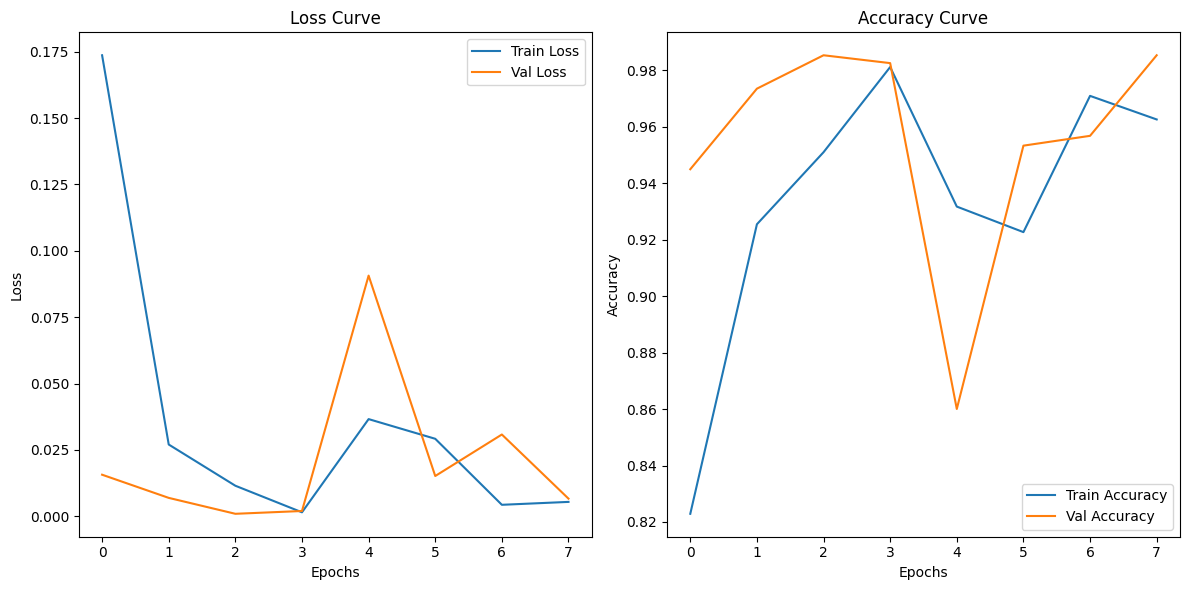

Trained Model saved to trained_model_CRC_CBAM(transform).pth
              precision    recall  f1-score   support

         ADI       0.97      1.00      0.99       268
        BACK       1.00      0.93      0.97       169
         DEB       1.00      1.00      1.00        68
         LYM       0.99      1.00      1.00       127
         MUC       0.98      1.00      0.99       207
         MUS       0.95      1.00      0.98       118
        NORM       1.00      0.99      0.99       148
         STR       1.00      0.93      0.96        84
         TUM       1.00      1.00      1.00       247

    accuracy                           0.99      1436
   macro avg       0.99      0.98      0.99      1436
weighted avg       0.99      0.99      0.99      1436



In [21]:
############################ TRAIN AND TEST ON THE CRC-VAL-HE-7K DATASET  ###################################
############################ TRAIN TRANSFORM DIFFERENT FROM VAL_TEST TRANSFORM##########################

# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets


# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_CBAM(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=20)

joblib.dump(trained_model, '/kaggle/working/trained_model_CRC_CBAM(transform).pkl')
# Save the model's state dictionary
model_save_path = "trained_model_CRC_CBAM(transform).pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Trained Model saved to {model_save_path}")

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(trained_model, test_dataloader, device, class_names)

In [22]:
###################### TESTING ON PathMNIST DATASET (Model trained on crc-7k)########################

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Trained on CRC and testing on PathMNIST

test_dataset = PathMNIST(split="test", transform=transform, download=True)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
              precision    recall  f1-score   support

         ADI       0.67      0.99      0.80      1338
        BACK       0.00      0.02      0.01       847
         DEB       1.00      0.04      0.07       339
         LYM       0.18      0.01      0.03       634
         MUC       0.00      0.00      0.00      1035
         MUS       0.55      0.35      0.43       592
        NORM       0.86      0.21      0.33       741
         STR       0.34      0.28      0.31       421
         TUM       0.99      0.07      0.12      1233

    accuracy                           0.27      7180
   macro avg       0.51      0.22      0.23      7180
weighted avg       0.51      0.27      0.26      7180



In [11]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])

# Apply the transformations to the train and validation datasets
# Set download=True to download the dataset
train_dataset = PathMNIST(split="train", transform=transform, download=True)
val_dataset = PathMNIST(split="val", transform=transform, download=True)

# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Combine the dataloaders into a dictionary
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Print the dataset sizes to verify
print("Training dataset size:", dataset_sizes['train'])
print("Validation dataset size:", dataset_sizes['val'])

100%|██████████| 205615438/205615438 [00:16<00:00, 12759731.91it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Training dataset size: 89996
Validation dataset size: 10004


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]


Epoch 1/10
----------------------------------------
train Loss: 0.0528 Acc: 0.8951
--------------------
val Loss: 0.0627 Acc: 0.9319
--------------------
Epoch 2/10
----------------------------------------
train Loss: 0.0175 Acc: 0.9323
--------------------
val Loss: 0.0040 Acc: 0.9666
--------------------
Epoch 3/10
----------------------------------------
train Loss: 0.0111 Acc: 0.9463
--------------------
val Loss: 0.0117 Acc: 0.9592
--------------------
Epoch 4/10
----------------------------------------
train Loss: 0.0086 Acc: 0.9541
--------------------
val Loss: 0.0076 Acc: 0.9521
--------------------
Epoch 5/10
----------------------------------------
train Loss: 0.0063 Acc: 0.9584
--------------------
val Loss: 0.0205 Acc: 0.9554
--------------------
Epoch 6/10
----------------------------------------
train Loss: 0.0057 Acc: 0.9621
--------------------
val Loss: 0.3661 Acc: 0.9314
--------------------
Epoch 7/10
----------------------------------------
train Loss: 0.0051 Acc: 

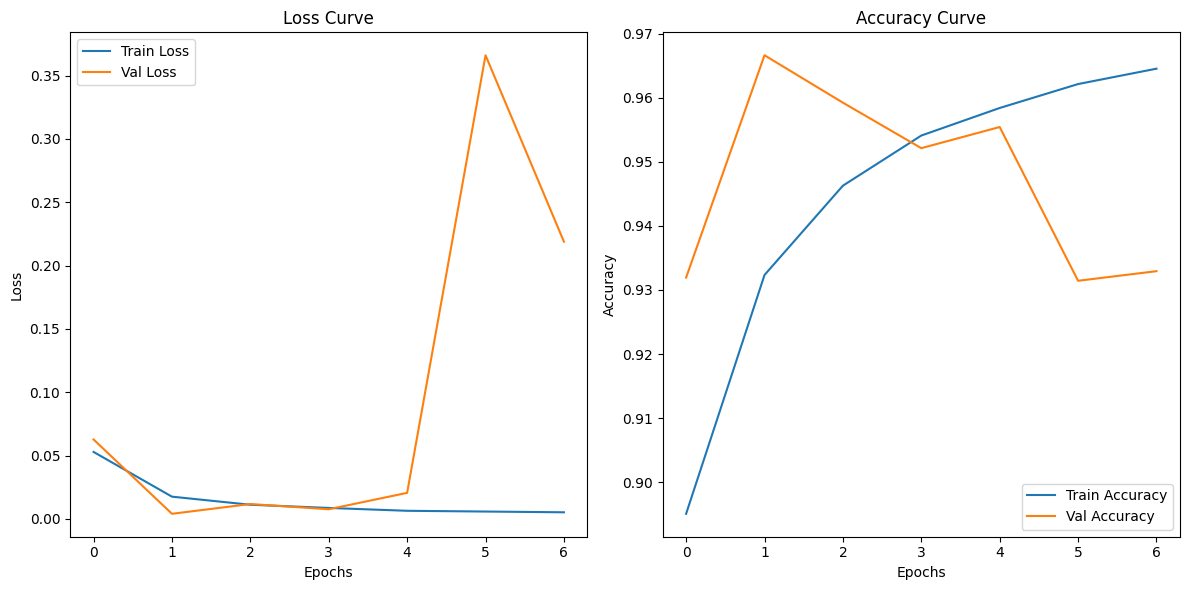

              precision    recall  f1-score   support

         ADI       0.96      0.87      0.91      1338
        BACK       0.85      0.79      0.82       847
         DEB       0.51      0.87      0.64       339
         LYM       0.94      0.79      0.86       634
         MUC       0.86      0.95      0.90      1035
         MUS       0.83      0.69      0.75       592
        NORM       0.83      0.98      0.90       741
         STR       0.63      0.64      0.63       421
         TUM       0.93      0.85      0.89      1233

    accuracy                           0.84      7180
   macro avg       0.81      0.83      0.81      7180
weighted avg       0.86      0.84      0.85      7180



In [13]:
# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedEfficientNetB0_CBAM(num_classes=9)  # Ensure this matches the dataset classes

# Train the model
trained_model = train_model(model, dataloaders, dataset_sizes, device=device, num_epochs=10)
joblib.dump(trained_model, '/kaggle/working/trained_model_PathMNIST_CBAM.pkl')

# Create a DataLoader for the test dataset (make sure to apply the same transform)
test_dataset = PathMNIST(split="test", transform=transform, download=False)
test_dataloader_PathMNIST = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
evaluate_model(trained_model, test_dataloader_PathMNIST, device, class_names)

In [14]:
# Save the model's state dictionary
model_save_path = "trained_model_PathMNIST_CBAM.pth"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to trained_model_PathMNIST_CBAM.pth


In [16]:


# Set CUDA_LAUNCH_BLOCKING for synchronous error reporting
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load your dataset without transformations initially
dataset = datasets.ImageFolder("/kaggle/input/crc-val-he-7k/CRC-VAL-HE-7K")

# Check the number of classes and label ranges
print("Number of classes:", len(dataset.classes))
for _, label in dataset:
    assert 0 <= label < 9, f"Label {label} is out of bounds!"

# Split dataset into training (60%), validation (20%), and testing (20%) sets

# Split indices with stratification
train_indices, temp_indices = train_test_split(
    list(range(len(dataset))), test_size=0.4, stratify=dataset.targets
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, stratify=[dataset.targets[i] for i in temp_indices]
)

# Create Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Assign the transform attribute to each dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dynamically add the transform attribute to Subsets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders for training, validation, and testing
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Combine the dataloaders into a dictionary
crc_dataloaders  = {
    'train': train_dataloader,
    'val': val_dataloader
}

# Dataset sizes
crc_dataset_sizes  = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}


Number of classes: 9


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_23/1383849159.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models f

Epoch 1/50
----------------------------------------
train Loss: 0.1883 Acc: 0.7818
--------------------
val Loss: 0.4009 Acc: 0.7187
--------------------
Epoch 2/50
----------------------------------------
train Loss: 0.1060 Acc: 0.8222
--------------------
val Loss: 0.2628 Acc: 0.7549
--------------------
Epoch 3/50
----------------------------------------
train Loss: 0.0718 Acc: 0.8556
--------------------
val Loss: 0.1175 Acc: 0.8231
--------------------
Epoch 4/50
----------------------------------------
train Loss: 0.0558 Acc: 0.8677
--------------------
val Loss: 0.0952 Acc: 0.8343
--------------------
Epoch 5/50
----------------------------------------
train Loss: 0.0436 Acc: 0.8774
--------------------
val Loss: 0.1333 Acc: 0.8175
--------------------
Epoch 6/50
----------------------------------------
train Loss: 0.0436 Acc: 0.8795
--------------------
val Loss: 0.0706 Acc: 0.8642
--------------------
Epoch 7/50
----------------------------------------
train Loss: 0.0342 Acc: 

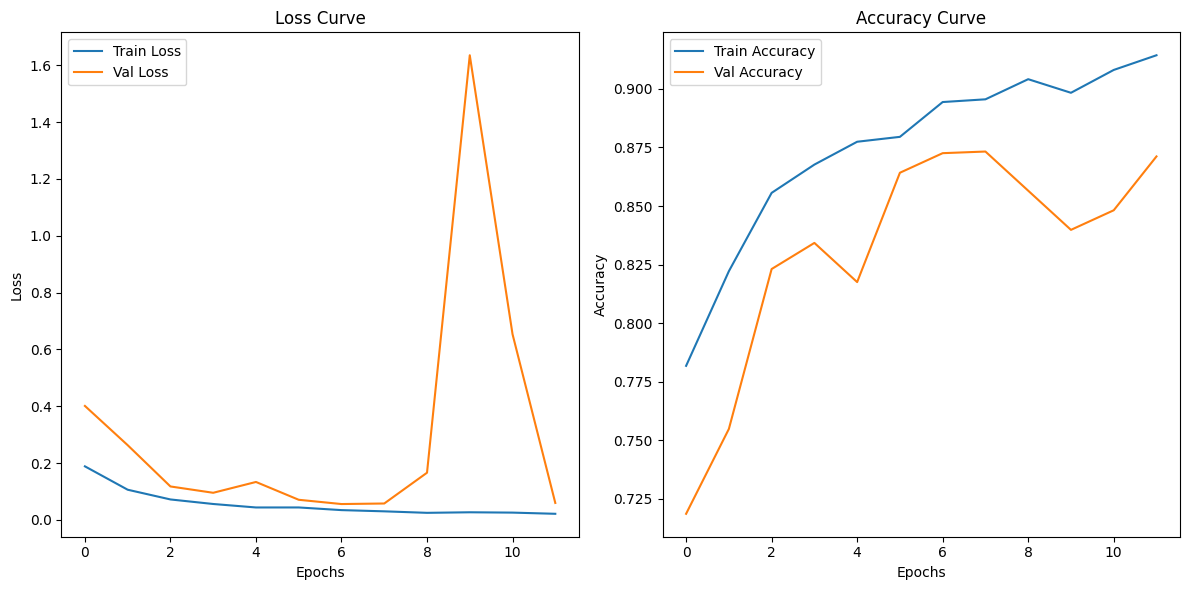

Finetuned Model saved to finetuned_model_PathMNIST_CBAM.pth


In [17]:
# Load the pretrained model
model = ModifiedEfficientNetB0_CBAM(num_classes=9)  # Ensure this matches the dataset classes
pretrained_model_path = "/kaggle/working/trained_model_PathMNIST_CBAM.pth"  # Replace with your saved PathMNIST model path
model.load_state_dict(torch.load(pretrained_model_path))  # Load pretrained weights

# Step 3: Adjust the model for finetuning
# Freeze earlier layers (optional for transfer learning)
for param in model.efficientnet_b0.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Ensure classifier is trainable
for param in model.efficientnet_b0.classifier.parameters():
    param.requires_grad = True

# Finetune the model on CRC-VAL-HE-7K
finetuned_model = train_model(
    model,
    dataloaders=crc_dataloaders,
    dataset_sizes=crc_dataset_sizes,
    device=device,
    num_epochs=50,
    learning_rate=1e-4,  # Use a lower learning rate for finetuning
    patience=5  # Early stopping patience
)

joblib.dump(finetuned_model, '/kaggle/working/finetuned_model_PathMNIST_CBAM.pkl')
# Save the model's state dictionary
model_save_path = "finetuned_model_PathMNIST_CBAM.pth"
torch.save(finetuned_model.state_dict(), model_save_path)
print(f"Finetuned Model saved to {model_save_path}")


In [18]:
# Evaluate the model on the test set
class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'] 
evaluate_model(finetuned_model, test_dataloader, device, class_names)

              precision    recall  f1-score   support

         ADI       0.98      0.86      0.92       267
        BACK       0.99      0.99      0.99       169
         DEB       0.73      0.60      0.66        68
         LYM       0.78      1.00      0.88       127
         MUC       0.99      0.86      0.92       207
         MUS       0.57      0.91      0.70       119
        NORM       0.99      0.95      0.97       148
         STR       0.88      0.45      0.60        84
         TUM       0.85      0.90      0.88       247

    accuracy                           0.87      1436
   macro avg       0.86      0.84      0.84      1436
weighted avg       0.89      0.87      0.87      1436

